# Figure S1: EI dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import h5py

import EIANN.utils as ut
import EIANN.plot as pt
from EIANN.generate_figures import *

pt.update_plot_defaults()
root_dir = ut.get_project_root()

%load_ext autoreload
%autoreload 2

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/utils/representation_analysis.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
figure_name = "FigS1_dynamics"
model_list = ["bpDale_learned", "HebbWN_topsup", "bpLike_WT_hebbdend"]
model_dict_all = load_model_dict()
generate_hdf5_all_seeds(model_list, model_dict_all, dataset='MNIST', variables_to_save = ['activity_dynamics'], recompute=None)

Generating plots for Backprop (EIANN)
Generating plots for Hebb (EIANN)
Generating plots for Dend. Target Prop.


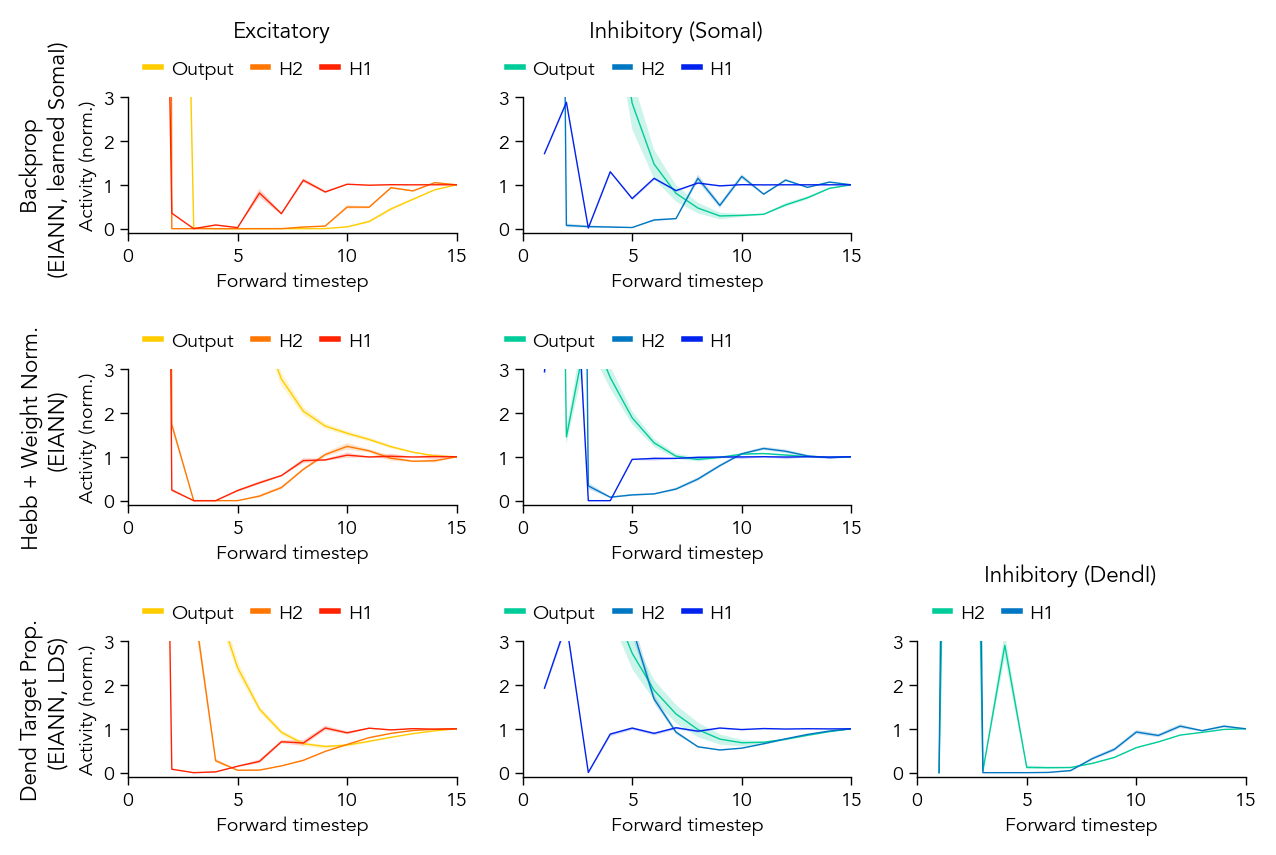

In [27]:
fig = plt.figure(figsize=(6.5, 4))
axes = gs.GridSpec(nrows=3, ncols=3, figure=fig,                       
                    left=0.1,right=0.96,
                    top=0.9, bottom=0.05,
                    wspace=0.2, hspace=1)

def get_layer_name(pop_name):
    split_strings = re.findall(r'[A-Z][a-z\d]*', pop_name)
    return split_strings[0]

model_dict_all["bpDale_learned"]["display_name"] = "Backprop \n (EIANN, learned SomaI)"
model_dict_all["HebbWN_topsup"]["display_name"] = "Hebb + Weight Norm. \n (EIANN)"
model_dict_all["bpLike_WT_hebbdend"]["display_name"] = "Dend Target Prop. \n (EIANN, LDS)"

for row, model_key in enumerate(model_list):
    model_dict = model_dict_all[model_key]
    network_name = model_dict['config'].split('.')[0]
    hdf5_path = root_dir + f"/EIANN/data/model_hdf5_plot_data/plot_data_{network_name}.h5"
    with h5py.File(hdf5_path, 'r') as f:
        data_dict = f[network_name]
        print(f"Generating plots for {model_dict['label']}")    

        dynamics_all_seeds = {}
        for seed in model_dict['seeds']:
            pop_dynamics_dict = data_dict[seed]['activity_dynamics']
            for pop_name, pop_dynamics in pop_dynamics_dict.items():
                if pop_name not in dynamics_all_seeds:
                    dynamics_all_seeds[pop_name] = []
                avg_dynamics = np.mean(pop_dynamics, axis=(1,2))
                avg_dynamics = avg_dynamics/avg_dynamics[-1]
                dynamics_all_seeds[pop_name].append(avg_dynamics)
        dynamics_all_seeds = {pop_name:np.array(dynamics) for pop_name, dynamics in dynamics_all_seeds.items()}

        for col in range(3):
            ax = fig.add_subplot(axes[row, col])

            if col == 0:
                E_populations = {pop_name:pop_dynamics for pop_name,pop_dynamics in dynamics_all_seeds.items() if 'E' in pop_name and 'Input' not in pop_name}
                cmap = plt.get_cmap('autumn_r')
                for i, (pop_name, pop_dynamics) in enumerate(E_populations.items()):
                    avg_dynamics = np.mean(pop_dynamics, axis=(0))
                    error = np.std(pop_dynamics, axis=0)
                    color = cmap(0.2 + i/3)
                    ax.plot(np.arange(1,16), avg_dynamics, label=get_layer_name(pop_name), color=color)
                    ax.fill_between(np.arange(1,16), avg_dynamics-error, avg_dynamics+error, alpha=0.2, linewidth=0,  color=color)
                legend = ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(-0., 1.4), frameon=False, handlelength=0.8, handletextpad=0.5, columnspacing=1)
                for line in legend.get_lines():
                    line.set_linewidth(2)

            elif col == 1:
                I_populations = {pop_name:pop_dynamics for pop_name,pop_dynamics in dynamics_all_seeds.items() if 'SomaI' in pop_name}
                cmap = plt.get_cmap('winter_r')
                for i, (pop_name, pop_dynamics) in enumerate(I_populations.items()):
                    avg_dynamics = np.mean(pop_dynamics, axis=(0))
                    error = np.std(pop_dynamics, axis=0)
                    color = cmap(0.2 + i/3)
                    ax.plot(np.arange(1,16), avg_dynamics, label=get_layer_name(pop_name), color=color)
                    ax.fill_between(np.arange(1,16), avg_dynamics-error, avg_dynamics+error, alpha=0.2, linewidth=0,  color=color)
                legend = ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(-0.1, 1.4), frameon=False, handlelength=0.8, handletextpad=0.5, columnspacing=1)
                for line in legend.get_lines():
                    line.set_linewidth(2)

            elif col == 2:
                DendI_populations = {pop_name:pop_dynamics for pop_name,pop_dynamics in dynamics_all_seeds.items() if 'DendI' in pop_name}
                if len(DendI_populations) > 0:
                    cmap = plt.get_cmap('winter_r')
                    for i, (pop_name, pop_dynamics) in enumerate(DendI_populations.items()):
                        avg_dynamics = np.mean(pop_dynamics, axis=(0))
                        error = np.std(pop_dynamics, axis=0)
                        color = cmap(0.2 + i/3)
                        ax.plot(np.arange(1,16), avg_dynamics, label=get_layer_name(pop_name), color=color)
                        ax.fill_between(np.arange(1,16), avg_dynamics-error, avg_dynamics+error, alpha=0.2, linewidth=0,  color=color)
                    legend = ax.legend(ncol=3, loc='upper left', bbox_to_anchor=(-0., 1.4), frameon=False, handlelength=0.8, handletextpad=0.5, columnspacing=1)
                    for line in legend.get_lines():
                        line.set_linewidth(2)
                else:
                    ax.set_axis_off()

            ax.set_xticks(np.arange(0, 16, 5))
            ax.set_yticks(np.arange(0, 3.1, 1))
            ax.set_ylim([-0.1, 3])
            ax.set_xlim([1, 15])
            ax.set_xticks([0, 5, 10, 15])
            ax.set_xlabel('Forward timestep')
            if col == 0:
                ax.set_ylabel('Activity (norm.)', fontsize=7)
                ax.set_title(model_dict['display_name'], rotation=90, x=-0.25, y=0.4, va='center', fontsize=8)

            if row==0 and col==0:
                ax.text(7, 4.5, 'Excitatory', ha='center', va='center', fontsize=8)
            elif row==0 and col==1:
                ax.text(7, 4.5, 'Inhibitory (SomaI)', ha='center', va='center', fontsize=8)
            elif row==2 and col==2:
                ax.text(7, 4.5, 'Inhibitory (DendI)', ha='center', va='center', fontsize=8)

fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.svg", dpi=300)
fig.savefig(f"{root_dir}/EIANN/figures/{figure_name}.png", dpi=300)